<a href="https://colab.research.google.com/github/DDoeuiGongju/DoItDeeplearning/blob/main/05_%ED%9B%88%EB%A0%A8%EB%85%B8%ED%95%98%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"어느 한 데이터셋에만 치우친 모델을 만들지 않기"

In [ ]:
# 로지스틱 회귀로 훈련(train) 및 평가(test)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [ ]:
# 서포트 벡터 머신(SVM)으로 모델 훈련하고 평가하기
# SVM: 훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업
# loss의 매개변수 log → hinge
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

SGDClassifier클래스의 다른 매개변수와 그 값들을 바꾸며 성능을 개선해나간다.  
→ 모델을 튜닝한다.  

그러나 테스트 셋으로 모델을 튜닝하면 테스트 셋에 대해서만 좋은 성능을 보여주는 모델이 만들어진다.  
→ 테스트 셋의 정보가 모델에 새어 나감: **"일반화 성능 왜곡"**  

해결 방법: 테스트 셋은 실전투입 전 한번만 사용하고 모델 튜닝을 위한 셋은 따로 준비한다.

### 검증 세트(validation set/devel set)


> 훈련 세트에서 조금 떼어 만든다. 
- 전체 데이터 셋을 8:2로 나눈 후 8을 다시 8:2로 나눈다.
- ex) 훈련 셋(80%) / 테스트 셋(20%) → 훈련 셋(64%) / 검증 셋(16%) / 테스트 셋(20%)
- 훈련 셋이 너무 작아지면 학습을 위한 데이터가 부족해짐으로 주의한다.



In [ ]:
# 1. 데이터 셋 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 2. 검증 셋 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print('훈련 셋: {}  검증 셋: {},  테스트 셋: {}'.format(len(x_train), len(x_val), len(x_test)))

# 3. 검증 셋 사용해 모델 평가
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)


# 데이터 수가 적어 검증 셋의 비율이나 random_state의 매개변수 값을 조금만 조절해도 성능 평가 점수가 크게 바뀐다.
# 이런 경우 검증 셋을 나누지 않고 교차 검증(cross validation) 방법을 사용하기도 한다.

훈련 셋: 364  검증 셋: 91,  테스트 셋: 114


0.6923076923076923

### 데이터 전처리


> 실전에서 수집된 데이터의 경우 데이터를 적절히 가공하는 데이터 전처리가 필요할 수 있다. **특성의 스케일이 다른 경우**에는 잘 가공된 데이터도 전처리가 필요하다.
- 특성의 스케일: 특성이 가지고 있는 값의 범위

유방암 데이터의 3, 4번 특성: ['mean perimeter' 'mean area']


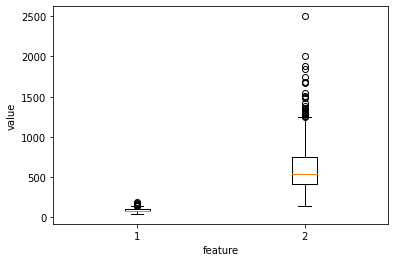

In [ ]:
''' 스케일을 조정하지 않고 스케일 비교하기 '''
# 1. 훈련데이터 준비하고 스케일 비교하기
import matplotlib.pyplot as plt

print('유방암 데이터의 3, 4번 특성:', cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()
# 두 특성의 스케일 차이가 크다.

In [ ]:
# 2. 가중치를 기록할 변수와 학습률 파라미터 추가
# 3. 가중치 기록하고 업데이트 양 조절
# 04의 Single Layer사용
class SingleLayer:
    def __init__(self, learning_rate=0.1): 
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []       # 가중치 기록할 리스트
        self.lr = learning_rate   # 학습률: 이 값으로 가중치의 업데이트 양 조절.
                                #         적절한 값을 적용해 전역 최솟값을 놓치지 않도록 한다.
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b   
        return z

    def activation(self, z):     
        a = 1 / (1 + np.exp(-z))   
        return a

    def backprop(self, x, err):
        w_grad = x * err  
        b_grad = 1 * err   
        return w_grad, b_grad

    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])                        
        self.b = 0                                          
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))   
            for i in indexes:                                    
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad * self.lr             # 학습률 적용해 가중치 업데이트 양 조절
                self.b -= b_grad
                self.w_history.append(self.w.copy())   # 가중치 기록.
                                                    # 배열을 리스트에 추가하면 값이 들어가지 않고 배열을 참조만 함으로 배열 값을 직접 복사해 리스트에 추가
                a = np.clip(a, 1e-10, 1-1e-10)                    
                loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))
            self.losses.append(loss/len(y))                   

    def predict(self, x):            
        z = [self.forpass(x_i) for x_i in x]  
        return np.array(z) > 0                 
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


정확도: 0.9120879120879121


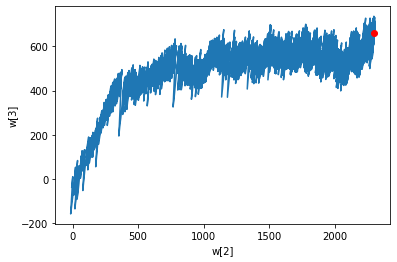

In [ ]:
# 4. 모델 훈련 및 평가
import numpy as np

layer = SingleLayer()
layer.fit(x_train, y_train)
print('정확도:', layer.score(x_val, y_val))

# layer객체의 인스턴스 변수 w_history에는 100번의 에폭동안 변경된 가중치가 모두 포함돼있다.
w2 = []
w3 = []
for w in layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')   # 최종 가중치
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w3값은 학습과정에서 큰 폭으로 흔들리며 변화하지만 w2값은 0부터 시작해 조금씩 최적값에 가까워짐을 확인  
이를 **"w3에 대한 gradient가 크기 때문에 w3축을 따라 가중치가 크게 요동치고 있다"**고 한다. ==> 모델이 불안정하게 수렴  

이 현상이 특성의 스케일이 다른 경우 생기는 문제이다.

### 스케일 조정을 통한 모델 훈련


> 신경망에서 주로 사용하는 스케일 조정 방법은 **표준화**이다.
- 표준화(standardization): 특성값에서 평균을 빼고 표준편차로 나눈다.
    - 평균이 0이고 분산이 1인 특성이 만들어진다.
    - z = (x-m)/s
    - 사이킷런의 StandardScaler 



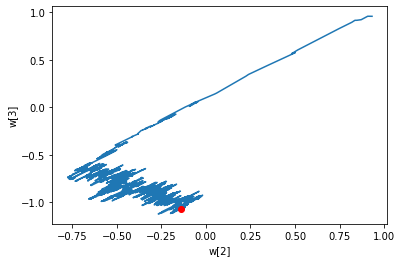

In [ ]:
# 1. 넘파이로 표준화 구현
# axis=0: 2차원 배열의 열을 기준으로 계산해 하나의 행 벡터로 반환(1이면 행기준 계산)
train_mean = np.mean(x_train, axis=0)   # 평균
train_std = np.std(x_train, axis=0)     # 표준편차
x_train_scaled = (x_train - train_mean) / train_std

# 2. 모델 훈련
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')   # 최종 가중치
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w2와 w3의 gradien가 비슷해 가중치가 대각선 방향으로 이동   
두 특성의 스케일을 비슷하게 맞췄으므로 최적값에 빠르게 근접

In [ ]:
# 3. 검증 셋으로 모델의 성능 평가
print("스케일 표준화 후 정확도(검증셋 수정X):",layer2.score(x_val, y_val))

val_mean = np.mean(x_val, axis=0)   # 평균
val_std = np.std(x_val, axis=0)     # 표준편차
x_val_scaled = (x_val - val_mean) / val_std
print("스케일 표준화 후 정확도(검증셋 수정O):",layer2.score(x_val_scaled, y_val))

스케일 표준화 후 정확도(검증셋 수정X): 0.37362637362637363
스케일 표준화 후 정확도(검증셋 수정O): 0.967032967032967


※ 훈련셋과 검증셋이 다른 비율로 스케일이 조정되지 않도록 주의해야 한다.

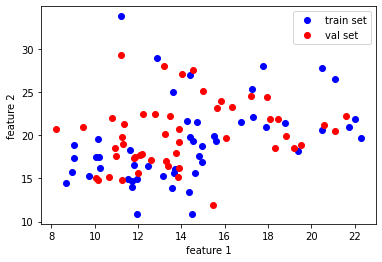

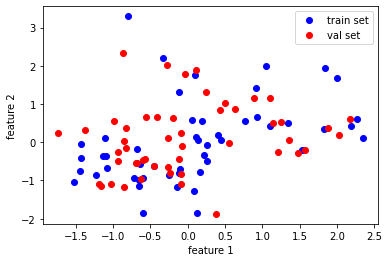

In [ ]:
# 원본 훈련셋과 검증셋으로 산점도 그리기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val set'])
plt.show()

# 전처리한 훈련셋과 검증셋으로 산점도 그리기
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val set'])
plt.show()

미세하지만 각각 다른 비율로 변환되었음을 알 수 있다.  
이는 훈련셋과 검증셋을 각각 다른 비율로 전처리했기 떄문이다.  
→ 훈련셋의 평균, 표준 편차를 이용해 검증셋을 변환

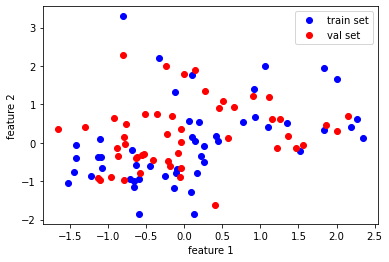

같은 비율로 전처리 한 후 정확도: 0.967032967032967


In [ ]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val set'])
plt.show()

print("같은 비율로 전처리 한 후 정확도:",layer2.score(x_val_scaled, y_val))   
# 검증셋이 크다면 성능 차이가 났을 것이다.

### 과대적합과 과소적합


> - 과대적합: 훈련셋에서는 좋은 성능을 내지만 검증셋에서는 낮은 성능을 내는 경우. 분산이 크다고 한다.
    - 원인: 훈련셋에 충분히 다양한 패턴의 샘플 포함 X 
    - 해결방법1: 너 많은 훈련셋을 모은다. 
    - 해결방법2: 훈련셋에 집착하지 않도록 가중치를 제한한다. → 모델 복잡도를 낮춘다.
- 과소적합: 훈련셋과 검증셋의 성능 차이는 크지 않으나 모두 낮은 성능을 내는 경우. 편향이 크다고 한다.
    - 원인: 모델이 충분히 복잡하지 않아 훈련데이터의 패턴을 모두 잡지 못한다.
    - 해결방법: 복잡도가 높은 모델을 사용하거나 가중치의 규제를 완화한다. 


> 에폭에 대한 손실함수 그래프(학습 곡선)를 이용해 과대.과소 적합을 분석하기도 한다.
- 훈련셋의 손실은 에폭이 진행될수록 감소하지만 검증셋의 손실은 최적점이 지나면 상승한다. 이는 모델이 과적합 되기 시작했다는 것이다.


> 모델복잡도에 대한 손실함수 그래프로도 분석할 수 있다.
- 모델 복잡도란 모델이 가진 학습 가능한 가중치 개수를 말한다.
- 모델이 복잡해지고 훈련셋에만 잘 맞는 형태로 만들어지면 과적합이 발생한다.

### Bias-variance tradeoff
> 과소적합된 모델(편향)과 과대적합된 모델(분산) 사이의 관계. 훈련셋의 성능과 검증셋과의 성능 차에 대한 적절한 지점을 찾아야 한다.

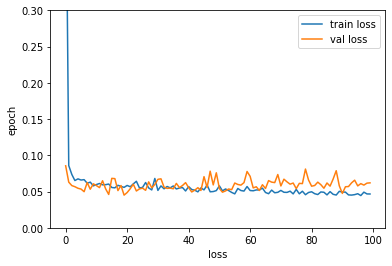

In [ ]:
# 경사하강법의 에폭 횟수에 대한 모델의 손실을 그래프로 그려 적절한 bias-variance tradeoff를 선택
# Single Layer사용
class SingleLayer:
    def __init__(self, learning_rate=0.1): 
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []   # 검증셋에 대한 손실을 기록하기 위한 인스턴스 변수 추가
        self.w_history = []      
        self.lr = learning_rate   

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b   
        return z

    def activation(self, z):     
        a = 1 / (1 + np.exp(-z))   
        return a

    def backprop(self, x, err):
        w_grad = x * err  
        b_grad = 1 * err   
        return w_grad, b_grad

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):   # fit에서 검증셋을 전달받을 수 있도록 x_val, y_val 매개변수 추가
        self.w = np.ones(x.shape[1])                        
        self.b = 0
        self.w_history.append(self.w.copy())                     # 가중치 기록
        np.random.seed(42)                                       # 무작위로 시드를 지정                                          
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))   
            for i in indexes:                                    
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= w_grad * self.lr 
                self.b -= b_grad
                self.w_history.append(self.w.copy()) 
                a = np.clip(a, 1e-10, 1-1e-10)                    
                loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))
            self.losses.append(loss/len(y))   
            self.update_val_loss(x_val, y_val)                   # 검증셋에 대한 손실 계산                

    def update_val_loss(self, x_val, y_val):
        if x_val is None: 
            return
        val_loss = 0
        for i in range(len(x_val)):                                                # fit의 훈련셋 손실 계산 방법과 동일
            z = self.forpass(x_val[i])                                             # 정방향 계산
            a = self.activation(z)                                                 # 활성화함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)                                         # 안전한 로그 계산을 위해 손실 누적
            val_loss += -(y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))   # 로지스틱 손실 함수 계산
        self.val_losses.append(val_loss/len(y_val))

    def predict(self, x):            
        z = [self.forpass(x_i) for x_i in x]  
        return np.array(z) > 0                 
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

# 모델 훈련
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

# 손실값으로 그래프 그려 에폭 횟수 지정
plt.ylim(0, 0.3)   # y범위 지정
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

In [ ]:
# 훈련 조기 종료
# 대략 20에폭부터 검증손실이 훈련손실보다 높아짐
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
print('에폭100 시 성능: {}\n에폭20 시 성능: {}'.format(layer3.score(x_val_scaled, y_val) ,layer4.score(x_val_scaled, y_val)))

# 과대적함 전 훈련을 멈췄으므로 성능 향상

에폭100 시 성능: 0.967032967032967
에폭20 시 성능: 0.978021978021978


### Regularization; 가중치 규제
> 가중치 값이 커지지 않도록 제한해 모델의 일반화 성능을 높인다.(절편은 규제X)
- L1규제: 손실 함수에 절댓값인 L1norm 더한다. 이때 그냥 더하지 않고 L1규제의 양을 조절하는 파라미터a를 곱한 후 더한다.
    - L1norm: 가중치의 절대값을 손실함수에 더한 것
    - 경사하강법으로 가중치를 업데이트하기 위해 L1규제를 적용한 로지스틱 손실 함수미분  
        - |w|를 미분하면 w의 부호만 남는다.
        - w_grad += alpha * np.sign(w)
    - L1규제는 가중치 크기에 따라 규제의 양이 변하지 않으므로 a에 의존한다. 그러므로 규제의 효과가 좋다고 할 수 없다.
    - 회귀모델에 L1규제를 추가한 것을 라쏘 모델이라고 한다. 이는 가중치를 줄이다 0으로 만들 수도 있다.
        - sklearn.linear_model.Lasso
- L2규제: 손실함수에 가중치에 대한 L2norm의 제곱을 더한다. 규제의 양을 조절하기 위해 a를 곱하고 미분결과를 보기좋게 하기 위해 1/2을 곱한다.
    - 경사하강법으로 가중치를 업데이트하기 위해 L2규제를 적용한 로지스틱 손실 함수미분  
        - L2규제를 미분하면 가중치벡터 w만 남는다.
        - w_grad += alpha * w
    - 회귀모델에 L2규제를 적용한 것을 릿지 모델이라고 한다.
        - sklearn.linear_model.Ridge

In [ ]:
# Single Layer사용
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):   # L1과 L2규제의 강도를 조절하는 매개변수 추가
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []  
        self.w_history = []      
        self.lr = learning_rate 
        self.l1 = l1   
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b   
        return z

    def activation(self, z):     
        a = 1 / (1 + np.exp(-z))   
        return a

    def backprop(self, x, err):
        w_grad = x * err  
        b_grad = 1 * err   
        return w_grad, b_grad

    def fit(self, x, y, epochs=100, x_val=None, y_val=None): 
        self.w = np.ones(x.shape[1])                        
        self.b = 0
        self.w_history.append(self.w.copy())                    
        np.random.seed(42)                                                                        
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))   
            for i in indexes:                                    
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w   # 가중치에 패널티의 미분값을 더한다
                self.w -= w_grad * self.lr 
                self.b -= b_grad
                self.w_history.append(self.w.copy()) 
                a = np.clip(a, 1e-10, 1-1e-10)                    
                loss += -(y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))
            self.losses.append(loss/len(y) + self.reg_loss())            # 학습셋 손실 계산 시 패널티 항 더함   
            self.update_val_loss(x_val, y_val)                         

    def update_val_loss(self, x_val, y_val):
        if x_val is None: 
            return
        val_loss = 0
        for i in range(len(x_val)):                      
            z = self.forpass(x_val[i])              
            a = self.activation(z)                                 
            a = np.clip(a, 1e-10, 1-1e-10)                                
            val_loss += -(y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())   # 검증셋 손실 계산 시 패널티 항 더함
    
    def reg_loss(self):   # 로지스틱 손실함수 계산에 패널티 항 추가를 위한 함수
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    def predict(self, x):            
        z = [self.forpass(x_i) for x_i in x]  
        return np.array(z) > 0                 
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

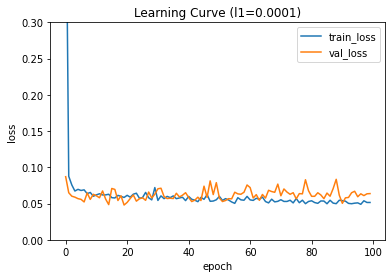

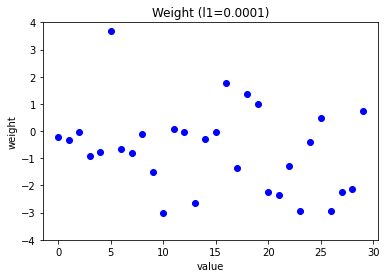

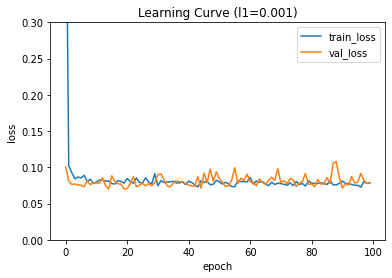

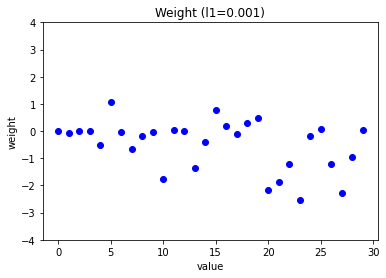

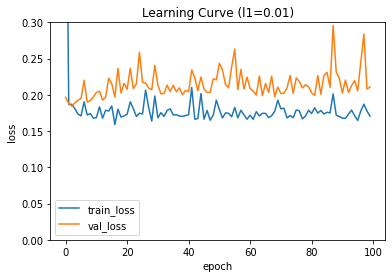

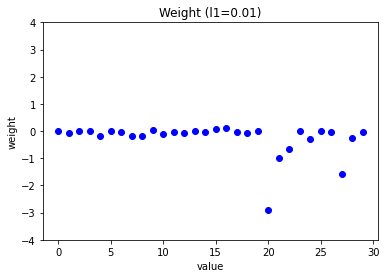

In [ ]:
# cancer데이터 셋에 L1규제 적용
l1_list = [0.0001, 0.001, 0.01]   # 규제 강도

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1={})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.xlabel('value')
    plt.ylabel('weight')
    plt.ylim(-4, 4)
    plt.show()

규제가 커질수록 훈련셋의 손실과 검증셋의 손실이 모두 높아진다. 즉, 과소적합 현상이 나타난다.   
가중치 그래프를 보면 규제 강도가 커질수록 가중치 값이 0에 가까워지는 것을 볼 수 있다.  
♪ 적절한 값은 0.001로 보여진다.


In [ ]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
print('L1규제 적용 성능(0.001):',layer5.score(x_val_scaled, y_val))

L1규제 적용 성능(0.001): 0.978021978021978


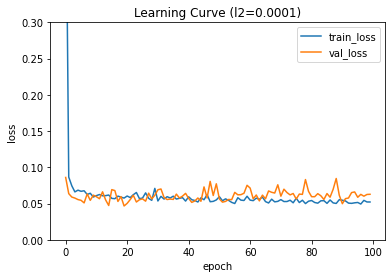

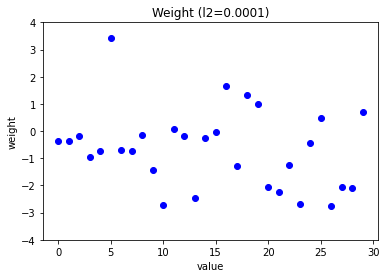

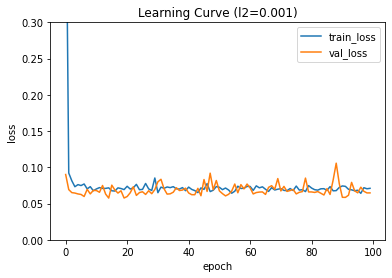

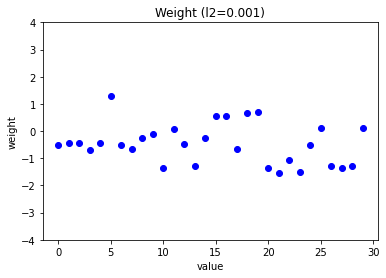

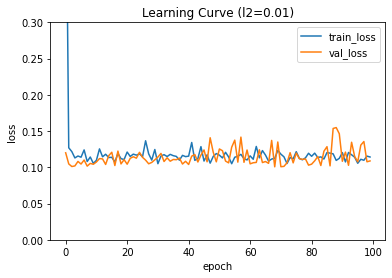

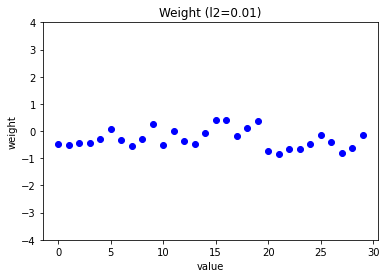

In [ ]:
# cancer데이터 셋에 L2규제 적용
l2_list = [0.0001, 0.001, 0.01]   # 규제 강도

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.xlabel('value')
    plt.ylabel('weight')
    plt.ylim(-4, 4)
    plt.show()

규제가 강해져도 L1만큼 과소적합이 심해지지 않는다.  
가중치가 0에 너무 가깝게 줄어들지 않는다.

In [ ]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
print('L2규제 적용 성능(0.01):',layer6.score(x_val_scaled, y_val))

L2규제 적용 성능(0.01): 0.978021978021978


L1규제와 L2규제의 결과가 동일하게 나왔다. cancer의 샘플 수가 매우 적어 둘의 성능차이가 크게 없다.

In [ ]:
# 검증 샘플에 대해 옳게 예측한 샘플 수(91개 中 89개)
np.sum(layer6.predict(x_val_scaled) == y_val)

89

그러나 L2의 에폭이 크게 늘어났다.이는 가중치를 강하게 제한했기 때문에 검증셋의 손실값을 유지하면서 알고리즘의 전역 최소값을 오랫동안 찾을 수 있던 것이다.

In [ ]:
# SGDClassifier에서 규제 적용하기
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
print('SGDClassifier l1규제 적용 성능:',sgd.score(x_val_scaled, y_val))

SGDClassifier l1규제 적용 성능: 0.978021978021978


### Cross validation; 교차검증
> 훈련셋에서 검증셋을 분리해 훈련셋 샘플 수가 줄어들어 모델 훈련 데이터가 부족해지는 경우에 사용.
- k-fold Cross validation
    1. 훈련셋을 k개의 fold로 나눈다.
    2. 첫번째 fold를 검증셋으로 평가한다.
    3. 모델 훈련 후 검증셋으로 평가한다.
    4. 차례대로 다음 fold를 검증셋으로 사용해 반복한다.
    5. k개의 검증셋으로 k번 성능평가 후 계산된 성능의 평균이 최종 성능이다.


In [ ]:
# k-fold Cross validation 구현
validation_scores = []   # 최종 검증 점수

k = 10
bins = len(x_train) // k   # 한 fold안에 들어갈 샘플의 수(//: 나눈 후 소수점 이하 버림)

for i in range(k):
    start = i * bins       # 검증 fold의 시작과 
    end = (i + 1) * bins   # 끝 인덱스
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]

    train_index = list(range(0, start)) + list(range(end, len(x_train)))   # 훈련 fold의 인덱스
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]

    # flod를 나눈 후 훈련데이터 표준화(전처리)를 해서 검증 폴드 정보의 누설을 방지한다.
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std

    lyr = SingleLayer(l2=0.01)
    lyr.fit(x_train_scaled, y_train, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)
print('k-fold Cross validation 최종 성능:', np.mean(validation_scores))

k-fold Cross validation 최종 성능: 0.975


In [ ]:
# 사이킷런을 이용한 교차 검증
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print('사이킷런을 이용한 k-fold Cross validation 최종 성능:', np.mean(scores['test_score']))

사이킷런을 이용한 k-fold Cross validation 최종 성능: 0.850096618357488


표준화 전처리를 수행하지 않아 성능이 낮게 나왔다.  
만일 전처리 후 cross_validate함수에 넣는다면 검증폴드가 전처리 단계에서 누설된다.
→ Pipeline class사용
- 표준화 단계와 SGDClassifier클래스 객체를 Pipeline으로 감싸 cross_validate함수에 전달한다. 그러면 cross_validate함수는 훈련셋을 나누기만 하고, 전처리 단계와 SGDClassifier클래스 객체의 호출은 Pipeline에서 이루어진다.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)   # 표준화 단계와 SGDClassifier클래스 객체를 Pipeline으로 감쌈
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print('Pipeline을 이용한 k-fold Cross validation 최종 성능(검증):', np.mean(scores['test_score']))
print('Pipeline을 이용한 k-fold Cross validation 최종 성능(훈련):', np.mean(scores['train_score']))

Pipeline을 이용한 k-fold Cross validation 최종 성능(검증): 0.9694202898550724
Pipeline을 이용한 k-fold Cross validation 최종 성능(훈련): 0.9875478561631581
